In [1]:
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential,Model,initializers,layers,Input
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import PIL
import PIL.Image

import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

In [26]:
data_dir = r'D:\Coding\DeepLearning\dataset\flowers'
batch_size = 16
img_height = 224
img_width = 224

In [27]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4323 files belonging to 5 classes.
Using 3459 files for training.


In [28]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4323 files belonging to 5 classes.
Using 864 files for validation.


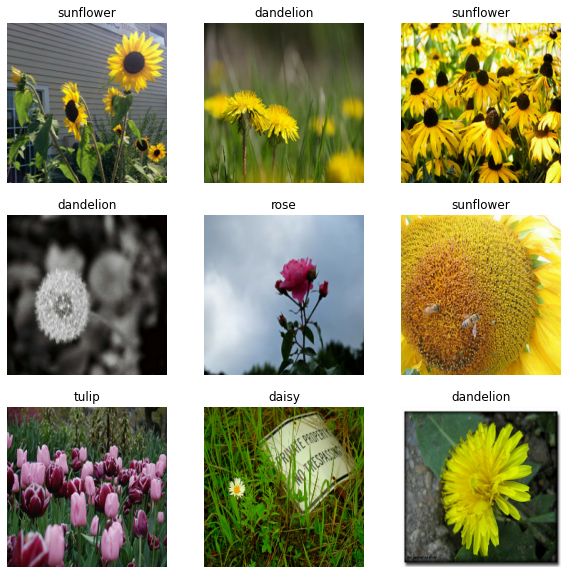

In [29]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [30]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
# resizing_layer = tf.keras.layers.experimental.preprocessing.Resizing(img_height, img_width)

In [31]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [32]:
VGG_16=Sequential([
        layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(kernel_size=(3,3),filters=64,strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),

        layers.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    
        layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),

        layers.Flatten(),
        layers.Dense(units=1024,activation='relu'),
        layers.Dense(units=1024,activation='relu'),
        layers.Dense(units=5,activation='softmax')
])

In [33]:
lr_rate=tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 30000, 0.93, staircase=False, name=None)

In [34]:
VGG_16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate),
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard

model_checkpoint_best_path=r'./models/VGG_16/'
model_checkpoint_best=ModelCheckpoint(filepath=model_checkpoint_best_path, monitor='val_accuracy', save_best_only=True, save_weights_only=True, save_freq='epoch')
early_stopping=EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-4)

log_dir=r'./models/log_dir/'
tensorboard_callback=TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
VGG_16.summary()

In [ ]:
plot_model(VGG_16,to_file='VGG_16.png',show_shapes=True)

In [ ]:
import visualkeras
visualkeras.layered_view(VGG_16, scale_xy=10, legend=True)

In [44]:
hist = VGG_16.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[model_checkpoint_best, early_stopping, tensorboard_callback], verbose=1)

Epoch 1/50
217/217 [==============================] - ETA: 0s - loss: 1.1949 - accuracy: 0.4961

ResourceExhaustedError: OOM when allocating tensor with shape[205520896,30] and type double on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:OneHot]

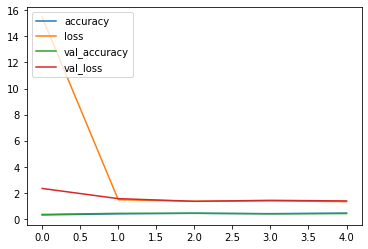

In [ ]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
loss, acc = VGG_16.evaluate(val_ds, verbose=1)
print(loss, acc)

54/54 [==============================] - 3s 54ms/step - loss: 1.3712 - accuracy: 0.4051
1.3711752891540527 0.40509259700775146


In [40]:
VGG_16.save("models/VGG_16_001.h5")